In [ ]:
import numpy as np

In [ ]:
P = 4096    #The number of grid points
N = P       # Dimensions of Covariance Matrix
sigma = 0.1     #Scaling parameter
A = 0.05           ## Normalizatin factor

n_samples = 25000

x = np.linspace(0 ,1-1/P, P)
def Covariance_Matrix(x):
    def distance(x1,x2):
        distx = np.abs(x1 - x2)
        if distx >= 0.5:
                    distx = 1.0 - distx
        return distx

    Cov_Matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            Cov_Matrix[i, j] = A * np.exp(-distance(x[i],x[j])**2 / (2 * sigma**2))
    return Cov_Matrix
Cov_Matrix = Covariance_Matrix(x)

def Eigenvalue_calculation(Cov_Matrix):
    eigenvalues, V = np.linalg.eig(Cov_Matrix)
    D = np.diag(eigenvalues)

    V = np.real(V)
    def diagonal_elements():
        Diagonal_elements = np.array([])
        for i in range(N):
            Diagonal_elements= np.append(Diagonal_elements, D[i,i])

        return Diagonal_elements
    def Eig_removal():
        diagonal = diagonal_elements()
        for k in range(len(diagonal_elements())):
            if diagonal[k] < 0:
                diagonal[k] = 0
        return diagonal
    Dtest = np.real(np.diag(Eig_removal()))
    F = V@np.sqrt(Dtest)
    return F
F = Eigenvalue_calculation(Cov_Matrix)

f = np.zeros((N,n_samples))
for i in range(n_samples):
    f[:,i] = np.dot(F,np.random.normal(0,1,(N)))

## Defined Values

In [ ]:
tmax = 0.03
dt = 0.01
M = round(tmax/dt)
O = int(M/2)

if P == 4096:
    Number_of_interogation_windows = 32
    N_regions_pixelation = int(P/4)

else:
    Number_of_interogation_windows = 16
    N_regions_pixelation = int(P/2)

IA_region_size = 32/N_regions_pixelation
N_particles = Number_of_interogation_windows*10
q = np.linspace(0,1,N_regions_pixelation)
t = np.linspace(0,1,Number_of_interogation_windows)
zeta = np.linspace(0,1,32)

peak_intensity = 250
particle_diameter = 2/P
image_size = P

one_pixel = 1/N_regions_pixelation
number_of_pixels_to_move = 8
pixel_to_move =np.arange(-(number_of_pixels_to_move)*one_pixel,(number_of_pixels_to_move+1)*one_pixel,one_pixel)
area_to_search = np.arange(0,(1-(1/P))+IA_region_size,IA_region_size)

## Functions

In [ ]:
def velocity_field_mean(velocities):
    velocity_step = int(len(velocities)/Number_of_interogation_windows)       ##Calculates how many points are there in 1 pixel.
    velocity_mean = np.zeros([Number_of_interogation_windows])
    assigned_velocity =np.zeros([len(velocities)])
                                                                        ##Takes every velocity_step number of points in the velocity array.
                                                                        ##Calculates the mean of these points and assigns it to an index in velocity mean
                                                                        ## assigned_velocity keeps the same shape as P by assinign the mean of Velocity_step to all the points.
    for i in range(0,len(velocities),velocity_step):
        z = int(i/velocity_step)
        region = velocities[i:i+velocity_step]
        velocity_mean[z] = np.mean(region)
        assigned_velocity[i:i+velocity_step] = velocity_mean[z]

    return velocity_mean, assigned_velocity

def homogenous_particle_seeding(N_particles):
        Initial_position = np.zeros([N_particles])
        particle_in_a_bin = int(N_particles/Number_of_interogation_windows)
        bin_edges = np.linspace(0,1,Number_of_interogation_windows+1)

        for i in range(Number_of_interogation_windows):
                a = np.random.uniform(bin_edges[i],bin_edges[i+1],particle_in_a_bin)
                Initial_position[i * particle_in_a_bin:(i + 1) * particle_in_a_bin] = a
        return Initial_position, bin_edges

def wrap_position(pos):
    return pos%1

def Velocity_Interpolation(current_position):
        diff_array = np.abs(x - current_position)                           ##Calculates the closest point in the "Continous grid" to the particle.
        Back_point_index = np.argmin(diff_array)                                               ##Selects the closest point before that location

        if x[Back_point_index] > current_position:
            Back_point_index = Back_point_index - 1

                                                                                                ##calculates the velocity values at these points
                                                                                                ##Fits a line between the two velocity values and calcultes the velcoity at the particle position.(interpolates velocity)
        velocity_forw = velocities[(Back_point_index + 1) % len(x)]
        velocity_back = velocities[Back_point_index]
        m = (velocity_forw - velocity_back) / (1 / P)
        b = velocity_back - m * x[Back_point_index]
        interpolated_velocities = m * current_position+ b

        return interpolated_velocities

def Rk4(xi, vxi, Forward_or_backward):
    slope_1_x = vxi
    x_half  = wrap_position(xi + slope_1_x*dt/2)

    slope_2_x = Velocity_Interpolation(x_half)

    x_quarter = wrap_position(xi + slope_2_x*dt/2)
    slope_3_x = Velocity_Interpolation(x_quarter)

    x_three_quarters = wrap_position(xi + slope_3_x*dt)
    slope_4_x = Velocity_Interpolation(x_three_quarters)


    if Forward_or_backward == 'Forward':
        next_position = xi + ((dt/6)*((slope_1_x)+ (2*slope_2_x)+(2*slope_3_x)+ slope_4_x))

    elif Forward_or_backward == 'Backward':
        next_position = xi - ((dt/6)*((slope_1_x)+ (2*slope_2_x)+(2*slope_3_x)+ slope_4_x))


    next_position = wrap_position(next_position)

    return next_position

def sub_pixel_interpolation(correlation_vector, peak_x):
    length = len(correlation_vector) -1
    if peak_x ==0 or peak_x ==length:
        return 0
    peak_point = correlation_vector[peak_x]
    back_point_x = correlation_vector[peak_x-1]
    front_point_x = correlation_vector[peak_x+1]
    correction_x = (np.log(back_point_x) - np.log(front_point_x))/(2*(np.log(back_point_x) + np.log(front_point_x)- 2*np.log(peak_point)))
    return correction_x


def space_mean_function():
                                                            ##Assigns the average of space_step points to an index in space mean (same as velcoity)
    space = x
    space_mean = np.zeros([N_regions_pixelation])
    space_step = int(N/N_regions_pixelation)

    for i in range(0,len(x),space_step):
        area = space[i:i+space_step]
        z = int(i/space_step)
        space_mean[z] = np.mean(area)
    return space_mean
space_mean = space_mean_function()

def intensity_vector_function(Two_columns):

    intensity_back = np.zeros((N_particles,image_size))
    intensity_forw = np.zeros((N_particles,image_size))

    for i in range(N_particles):                                        ##Using the formula in the book to convert positions into internsity profiles
        intensity_back[i,:] = peak_intensity*np.exp(-(x-Two_columns[i,0])**2/(particle_diameter**2/8))
        intensity_forw[i,:] = peak_intensity*np.exp(-(x-Two_columns[i,1])**2/(particle_diameter**2/8))
                                                                        ## Normalizes the peaks to 250 (some may have been lower due to finite resolution of continous grid P)
        if np.max(intensity_back[i,:]) > 150:
            max_intensity = np.argmax(intensity_back[i,:])
            intensity_back[i,max_intensity] = 250
        if np.max(intensity_forw[i,:]) > 150:
            max_intensity = np.argmax(intensity_forw[i,:])
            intensity_forw[i,max_intensity] = 250


    all_intensities_back = np.zeros([image_size])
    all_intensities_forw = np.zeros([image_size])

    for j in range (0,image_size):  ##Sums up at the intensity values at a specific location in space. The particles are now indistinguishable between images
        all_intensities_back[j] = np.sum(intensity_back[:,j])
        all_intensities_forw[j] = np.sum(intensity_forw[:,j])

                                                    ## Capping the intensities at 250 (so that if two particles are too close(closer than possible in experiment) they don't add up)
    for i in range(len(all_intensities_back)):
        if all_intensities_back[i] >250:
            all_intensities_back[i] = 250
        if all_intensities_forw[i] >250:
            all_intensities_forw[i] = 250

    return all_intensities_back,all_intensities_forw

def Noise(all_intensities_back,all_intensities_forw):
    Noise_max = 50
    Snap_1_Noise = np.random.uniform(0,Noise_max, size = len(all_intensities_back))
    Snap_2_Noise = np.random.uniform(0,Noise_max, size = len(all_intensities_forw))


    Noise_snap_1 = all_intensities_back + Snap_1_Noise
    Noise_snap_2 = all_intensities_forw + Snap_2_Noise
    return Noise_snap_1,Noise_snap_2 , Snap_1_Noise, Snap_2_Noise


def Gradient(all_intensities_back,all_intensities_forw):
    Gradient_max = np.random.randint(0,100)
    noise_gradient = Gradient_max*np.abs(np.linspace(0,1,len(all_intensities_back))-0.5)
    gradient_rolled = np.roll(noise_gradient,np.random.randint(-(int(len(all_intensities_back/2))),int(len(all_intensities_back)/2)))

    gradient_snap_1 = all_intensities_back + gradient_rolled
    gradient_snap_2 = all_intensities_forw+ gradient_rolled

    return gradient_snap_1, gradient_snap_2, gradient_rolled



def Noise_and_Gradient(all_intensities_back,all_intensities_forw, Snap_1_Noise, Snap_2_Noise, gradient_rolled):
    Noise_and_gradient_snap_1 = all_intensities_back + Snap_1_Noise + gradient_rolled
    Noise_and_gradient_snap_2 = all_intensities_forw + Snap_2_Noise + gradient_rolled

    return Noise_and_gradient_snap_1, Noise_and_gradient_snap_2

def pixelating_intensities(all_intensities_back, all_intensities_forw):
    intensity_step = int(len(all_intensities_back)/N_regions_pixelation)
    intensity_mean_back = np.zeros([N_regions_pixelation])
    intensity_mean_forw = np.zeros([N_regions_pixelation])

                                                                        ##Same procedure as pixelation of velocity and space.
                                                                        ##Takes intensity_step number of indices then calulacates their avergae and assigns it an index of intensity_mean_forw
    for i in range(0,P,intensity_step):
        z = int(i/intensity_step)
        region_back = all_intensities_back[i:i+intensity_step]
        intensity_mean_back[z] = np.mean(region_back)
        region_forw = all_intensities_forw[i:i+intensity_step]
        intensity_mean_forw[z] = np.mean(region_forw)

                                                                    ##Intensity_mean_back is SNAPSHOT 1 as it would be in PIV experiment
                                                                    ##Simialrly, Intensity_mean_forw is SNAPSHOT 2
    for i in range(len(intensity_mean_back)):
        if intensity_mean_back[i] >250:
            intensity_mean_back[i] = 250
        if intensity_mean_forw[i] >250:
            intensity_mean_forw[i] = 250

    return intensity_mean_back, intensity_mean_forw


def bad_correlation_check(correlation_matrix):
    maximum = np.zeros([len(correlation_matrix[:,0])])
    minimum = np.zeros([len(correlation_matrix[:,0])])
    for i in range(len(correlation_matrix[:,0])):
        maximum[i] = np.max(correlation_matrix[i,:])
        minimum[i] = np.min(correlation_matrix[i,:])
    avg_maximum = np.mean(maximum)
    avg_minimum = np.mean(minimum)
    correlation_matrix[correlation_matrix  < int(avg_maximum/4)] = np.nan
    return correlation_matrix


def Cross_Correlation(intensity_mean_back,intensity_mean_forw):
    ccr_matrix = np.zeros([len(area_to_search)-1,(pixel_to_move.size)])
    for i in range(len(area_to_search)-1):
        left_border = np.argmin(np.abs(space_mean-area_to_search[i]))%N_regions_pixelation
        right_border = np.argmin(np.abs(space_mean-area_to_search[i+1]))%N_regions_pixelation
        for j in range(0,len(pixel_to_move),1):
            if (area_to_search[i+1]+pixel_to_move[j]) >= 1-(1/P):

                r1 = np.argmin(np.abs(space_mean-(area_to_search[i]+ (pixel_to_move[j]))))%N_regions_pixelation
                r2 = np.argmin(np.abs(space_mean-(1 - area_to_search[i+1]+ (pixel_to_move[j]))))% N_regions_pixelation


                if intensity_mean_back[left_border:right_border].size < np.concatenate((intensity_mean_forw[r1:], intensity_mean_forw[:r2])).size:
                    left_border -=1

                if intensity_mean_back[left_border:right_border].size > np.concatenate((intensity_mean_forw[r1:], intensity_mean_forw[:r2])).size:

                    r2 +=1


                if r2 < r1:
                    Ia1  = intensity_mean_back[left_border:right_border]
                    Ia2 = np.concatenate((intensity_mean_forw[r1:], intensity_mean_forw[:r2]))

                else:
                    Ia1  = intensity_mean_back[left_border:right_border]
                    Ia2 = intensity_mean_forw[r1:r2]

            elif (area_to_search[i]+pixel_to_move[j]) < 0:
                r1 = np.argmin(np.abs(space_mean-(1-area_to_search[i]+ (pixel_to_move[j]))))%N_regions_pixelation
                r2 = np.argmin(np.abs(space_mean-( area_to_search[i+1]+ (pixel_to_move[j]))))%N_regions_pixelation


                if intensity_mean_back[left_border:right_border].size < np.concatenate((intensity_mean_forw[r1:], intensity_mean_forw[:r2])).size:

                    right_border +=1


                if intensity_mean_back[left_border:right_border].size > np.concatenate((intensity_mean_forw[r1:], intensity_mean_forw[:r2])).size:
                    r2 +=1

                if r1> r2:
                    Ia1  = intensity_mean_back[left_border:right_border]
                    Ia2 = np.concatenate((intensity_mean_forw[r1:], intensity_mean_forw[:r2]))
                else:

                    Ia1  = intensity_mean_back[left_border:right_border]
                    Ia2 = intensity_mean_forw[r1:r2]


            else:

                r1 = np.argmin(np.abs(space_mean-(area_to_search[i]+ (pixel_to_move[j]))))
                r2 = np.argmin(np.abs(space_mean-(area_to_search[i+1]+ (pixel_to_move[j]))))

                if intensity_mean_back[left_border:right_border].size < intensity_mean_forw[r1:r2].size:
                    right_border +=1

                elif intensity_mean_back[left_border:right_border].size > intensity_mean_forw[r1:r2].size:
                    r2 +=1

                Ia1  = intensity_mean_back[left_border:right_border]
                Ia2 = intensity_mean_forw[r1:r2]

            movement = np.dot(Ia1,Ia2)
            ccr_matrix[i,j] = movement
    return ccr_matrix

def PIV_velocity(ccr_matrix):
    sub_pixel_average_velocity = np.zeros(len(ccr_matrix[:,]))
    for k in range(len(ccr_matrix[:,])):
        index = np.argmax(ccr_matrix[k,:])
        sub_pixel_correction = sub_pixel_interpolation(ccr_matrix[k,:],index)
        sub_pixel_average_velocity[k] = (pixel_to_move[index] + sub_pixel_correction*one_pixel)/(dt*2)

    return sub_pixel_average_velocity

def outlier_correction(PIV_vector, threshold_factor=3):
    median = np.median(PIV_vector)  # Compute the median of the dataset
    mad = np.median(np.abs(PIV_vector - median))  # Compute MAD
    
    # Define threshold for detecting outliers
    threshold = threshold_factor * mad

    # Iterate through the vector to find and replace outliers
    for i in range(len(PIV_vector)):
        if np.abs(PIV_vector[i] - median) > threshold:
            PIV_vector[i] = (PIV_vector[i-1] + PIV_vector[i+1]) / 2  # Replace outlier with local interpolation
    
    return PIV_vector


In [ ]:
intensity_NN_back_Silent = np.zeros([int(P/4),n_samples])
intensity_NN_back_Noise = np.zeros([int(P/4),n_samples])
intensity_NN_back_Gradient = np.zeros([int(P/4),n_samples])
intensity_NN_back_Noise_and_Gradient = np.zeros([int(P/4),n_samples])

intensity_NN_forw_Silent = np.zeros([int(P/4),n_samples])
intensity_NN_forw_Noise = np.zeros([int(P/4),n_samples])
intensity_NN_forw_Gradient = np.zeros([int(P/4),n_samples])
intensity_NN_forw_Noise_and_Gradient = np.zeros([int(P/4),n_samples])

Averaged_velocities_NN = np.zeros([Number_of_interogation_windows,n_samples])

PIV_velocities_NN_Silent = np.zeros([Number_of_interogation_windows,n_samples])
PIV_velocities_NN_Noise = np.zeros([Number_of_interogation_windows,n_samples])
PIV_velocities_NN_Gradient = np.zeros([Number_of_interogation_windows,n_samples])
PIV_velocities_NN_Noise_and_Gradient = np.zeros([Number_of_interogation_windows,n_samples])

## Anything after this needs to be in the big loop

In [ ]:
for alpha in range(n_samples):
    velocities = f[:,alpha]

    velocity_mean, assigned_velocity = velocity_field_mean(velocities)

    Initial_position, bin_edges = homogenous_particle_seeding(N_particles)
    particle_positions = np.zeros((N_particles,M))
    particle_positions[:,O] = Initial_position

    for j in range(0, N_particles):
        for n in range(O, M-1, 1):
            interpolated_velocities = Velocity_Interpolation(particle_positions[j, n])
            particle_positions[j, n+1] = Rk4(particle_positions[j, n], interpolated_velocities, 'Forward')

    for j in range(N_particles):
        for n in range(O, 0, -1):
            interpolated_velocities = Velocity_Interpolation(particle_positions[j, n])
            particle_positions[j, n-1] = Rk4(particle_positions[j, n], interpolated_velocities , 'Backward')

    Two_columns = np.zeros([N_particles,2])
    Two_columns[:,0] = particle_positions[:, O-1]
    Two_columns[:,1] = particle_positions[:, O+1]

    all_intensities_back, all_intensities_forw = intensity_vector_function(Two_columns)
    all_intensities_back_Silent, all_intensities_forw_Silent = all_intensities_back, all_intensities_forw
    all_intensities_back_Noise, all_intensities_forw_Noise, Noise_Value_snap_1, Noise_Value_snap_2 = Noise(all_intensities_back,all_intensities_forw)
    all_intensities_back_Gradient, all_intensities_forw_Gradient, Gradient_Value = Gradient(all_intensities_back,all_intensities_forw)
    all_intensities_back_Noise_and_Gradient, all_intensities_forw_Noise_and_Gradient = Noise_and_Gradient(all_intensities_back,all_intensities_forw, Noise_Value_snap_1, Noise_Value_snap_2, Gradient_Value)

    intensity_mean_back_Silent, intensity_mean_forw_Silent = pixelating_intensities(all_intensities_back_Silent, all_intensities_forw_Silent)
    intensity_mean_back_Noise, intensity_mean_forw_Noise = pixelating_intensities(all_intensities_back_Noise, all_intensities_forw_Noise)
    intensity_mean_back_Gradient, intensity_mean_forw_Gradient = pixelating_intensities(all_intensities_back_Gradient, all_intensities_forw_Gradient)
    intensity_mean_back_Noise_and_Gradient, intensity_mean_forw_Noise_and_Gradient = pixelating_intensities(all_intensities_back_Noise_and_Gradient, all_intensities_forw_Noise_and_Gradient)


    intensity_NN_back_Silent[:,alpha] = intensity_mean_back_Silent
    intensity_NN_back_Noise[:,alpha] = intensity_mean_back_Noise
    intensity_NN_back_Gradient[:,alpha] = intensity_mean_back_Gradient
    intensity_NN_back_Noise_and_Gradient[:,alpha] = intensity_mean_back_Noise_and_Gradient

    intensity_NN_forw_Silent[:,alpha] = intensity_mean_forw_Silent
    intensity_NN_forw_Noise[:,alpha] = intensity_mean_forw_Noise
    intensity_NN_forw_Gradient[:,alpha] = intensity_mean_forw_Gradient
    intensity_NN_forw_Noise_and_Gradient[:,alpha] = intensity_mean_forw_Noise_and_Gradient


    #  ####  ccr_matrix = bad_correlation_check(ccr_matrix)

    ccr_matrix_Silent = Cross_Correlation(intensity_mean_back_Silent,intensity_mean_forw_Silent)
    ccr_matrix_Noise = Cross_Correlation(intensity_mean_back_Noise, intensity_mean_forw_Noise)
    ccr_matrix_Gradient = Cross_Correlation(intensity_mean_back_Gradient, intensity_mean_forw_Gradient)
    ccr_matrix_Noise_and_Gradient = Cross_Correlation(intensity_mean_back_Noise_and_Gradient, intensity_mean_forw_Noise_and_Gradient)

    sub_pixel_average_velocity_Silent = PIV_velocity(ccr_matrix_Silent)
    sub_pixel_average_velocity_Noise = PIV_velocity(ccr_matrix_Noise)
    sub_pixel_average_velocity_Gradient = PIV_velocity(ccr_matrix_Gradient)
    sub_pixel_average_velocity_Noise_and_Gradient = PIV_velocity(ccr_matrix_Noise_and_Gradient)

    Final_velocity_Silent = outlier_correction(sub_pixel_average_velocity_Silent)
    Final_velocity_Noise = outlier_correction(sub_pixel_average_velocity_Noise)
    Final_velocity_Gradient = outlier_correction(sub_pixel_average_velocity_Gradient)
    Final_velocity_Noise_and_Gradient = outlier_correction(sub_pixel_average_velocity_Noise_and_Gradient)


    Averaged_velocities_NN[:,alpha] = velocity_mean

    PIV_velocities_NN_Silent[:,alpha] = Final_velocity_Silent
    PIV_velocities_NN_Noise[:,alpha] = Final_velocity_Noise
    PIV_velocities_NN_Gradient[:,alpha] = Final_velocity_Gradient
    PIV_velocities_NN_Noise_and_Gradient[:,alpha] = Final_velocity_Noise_and_Gradient


In [ ]:
np.savetxt('/home/sashi/Desktop/Studies_Current_Variable/Input_Data/Testing_Data/July_17th_Averaged_velocities', Averaged_velocities_NN)

In [ ]:
np.savetxt('/home/sashi/Desktop/Studies_Current_Variable/Input_Data/Testing_Data/July_17th_PIV_velocities_Silent', PIV_velocities_NN_Silent)
np.savetxt('/home/sashi/Desktop/Studies_Current_Variable/Input_Data/Testing_Data/July_17th_PIV_velocities_Noise', PIV_velocities_NN_Noise)
np.savetxt('/home/sashi/Desktop/Studies_Current_Variable/Input_Data/Testing_Data/July_17th_PIV_velocities_Gradient', PIV_velocities_NN_Gradient)
np.savetxt('/home/sashi/Desktop/Studies_Current_Variable/Input_Data/Testing_Data/July_17th_PIV_velocities_Noise_and_Gradient', PIV_velocities_NN_Noise_and_Gradient)

In [ ]:
np.savetxt('/home/sashi/Desktop/Studies_Current_Variable/Input_Data/Testing_Data/July_17th_intensity_back_Silent', intensity_NN_back_Silent)
np.savetxt('/home/sashi/Desktop/Studies_Current_Variable/Input_Data/Testing_Data/July_17th_intensity_back_Noise', intensity_NN_back_Noise)
np.savetxt('/home/sashi/Desktop/Studies_Current_Variable/Input_Data/Testing_Data/July_17th_intensity_back_Gradient', intensity_NN_back_Gradient)
np.savetxt('/home/sashi/Desktop/Studies_Current_Variable/Input_Data/Testing_Data/July_17th_intensity_back_Noise_and_Gradient', intensity_NN_back_Noise_and_Gradient)

In [ ]:
np.savetxt('/home/sashi/Desktop/Studies_Current_Variable/Input_Data/Testing_Data/July_17th_intensity_forw_Silent',intensity_NN_forw_Silent)
np.savetxt('/home/sashi/Desktop/Studies_Current_Variable/Input_Data/Testing_Data/July_17th_intensity_forw_Noise',intensity_NN_forw_Noise)
np.savetxt('/home/sashi/Desktop/Studies_Current_Variable/Input_Data/Testing_Data/July_17th_intensity_forw_Gradient',intensity_NN_forw_Gradient)
np.savetxt('/home/sashi/Desktop/Studies_Current_Variable/Input_Data/Testing_Data/July_17th_intensity_forw_Noise_and_Gradient',intensity_NN_forw_Noise_and_Gradient)

In [ ]:
%reset

Nothing done.


#### To see plots

In [ ]:
import matplotlib.pyplot as plt

def intensity_mean_graph():
    fig, axs = plt.subplots(4, 2, figsize=(25, 12))  # Corrected figsize to (25, 12) for better height
    # Plotting on each subplot
    axs[0, 0].plot(q, intensity_mean_back_Silent, color='b')
    axs[0, 1].plot(q, intensity_mean_forw_Silent, color='r')
    axs[1, 0].plot(q, intensity_mean_back_Noise, color='b')
    axs[1, 1].plot(q, intensity_mean_forw_Noise, color='r')
    axs[2, 0].plot(q, intensity_mean_back_Gradient, color='b')
    axs[2, 1].plot(q, intensity_mean_forw_Gradient, color='r')
    axs[3, 0].plot(q, intensity_mean_back_Noise_and_Gradient, color='b')
    axs[3, 1].plot(q, intensity_mean_forw_Noise_and_Gradient, color='r')

    for i in range(4):  # Loop through rows
        axs[i, 0].set_xlabel('space')
        axs[i, 0].set_ylabel('intensity')
        axs[i, 1].set_xlabel('space')
        axs[i, 1].set_ylabel('intensity')
        axs[i, 0].set_title('Snapshot 1 (t)')
        axs[i, 1].set_title('Snapshot 2 (t+dt)')

    plt.tight_layout()  # Adjust spacing between subplots
    return  axs

def intensity_mean_overlap_graph():
    fig, ax = plt.subplots(figsize=(15, 8))  # Adjusted figsize for better visibility

    # Plotting all intensity mean data on the same graph
    ax.plot(q, intensity_mean_back_Silent, color ='r', label=' Silent')
    ax.plot(q, intensity_mean_back_Noise, color ='orange', label=' Noise')
    ax.plot(q, intensity_mean_back_Gradient, color ='b', label=' Gradient')
    ax.plot(q, intensity_mean_back_Noise_and_Gradient, color ='g', label=' Noise and Gradient')

    ax.set_xlabel('space')
    ax.set_ylabel('intensity')
    ax.set_title('Intensity Mean Overlap')
    ax.legend()  # Show legend with labels

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

def all_PIV_velocity_field_plots():
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))

    axs[0].plot(zeta, sub_pixel_average_velocity_Silent, 'o-', color='g', label='Silent')
    axs[1].plot(zeta, sub_pixel_average_velocity_Noise, 'o-', color='b', label='Noise')
    axs[2].plot(zeta, sub_pixel_average_velocity_Gradient, 'o-', color='r', label='Gradient')
    axs[3].plot(zeta, sub_pixel_average_velocity_Noise_and_Gradient, 'o-', color='purple', label='Noise and Gradient')

    # Setting titles, labels, and legends
    for ax, title in zip(axs, ['Silent', 'Noise', 'Gradient', 'Noise and Gradient']):
        ax.set_title(f'Velocity field ({title})')
        ax.set_xlabel('X')
        ax.set_ylabel('Velocity')
        ax.legend()

    plt.tight_layout()  # Adjust layout for better spacing
    return axs

def all_overlap_PIV_velocity_field_plots():
    fig, axs = plt.subplots(figsize=(20, 4))
    axs.plot(zeta, sub_pixel_average_velocity_Silent, 'o-', color='g', label='Silent')
    axs.plot(zeta, sub_pixel_average_velocity_Noise, 'o-', color='b', label='Noise')
    axs.plot(zeta, sub_pixel_average_velocity_Gradient, 'o-', color='r', label='Gradient')
    axs.plot(zeta, sub_pixel_average_velocity_Noise_and_Gradient, 'o-', color='purple', label='Noise and Gradient')
    axs.plot(x,velocities,'k', label = 'True value')
    # Setting titles, labels, and legends
    axs.set_title('PIV prediction of Velocity Fields')
    axs.set_xlabel('X')
    axs.set_ylabel('Velocity')
    axs.legend()
    axs.set_ylim(-0.5,0.5)
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()
    return axs

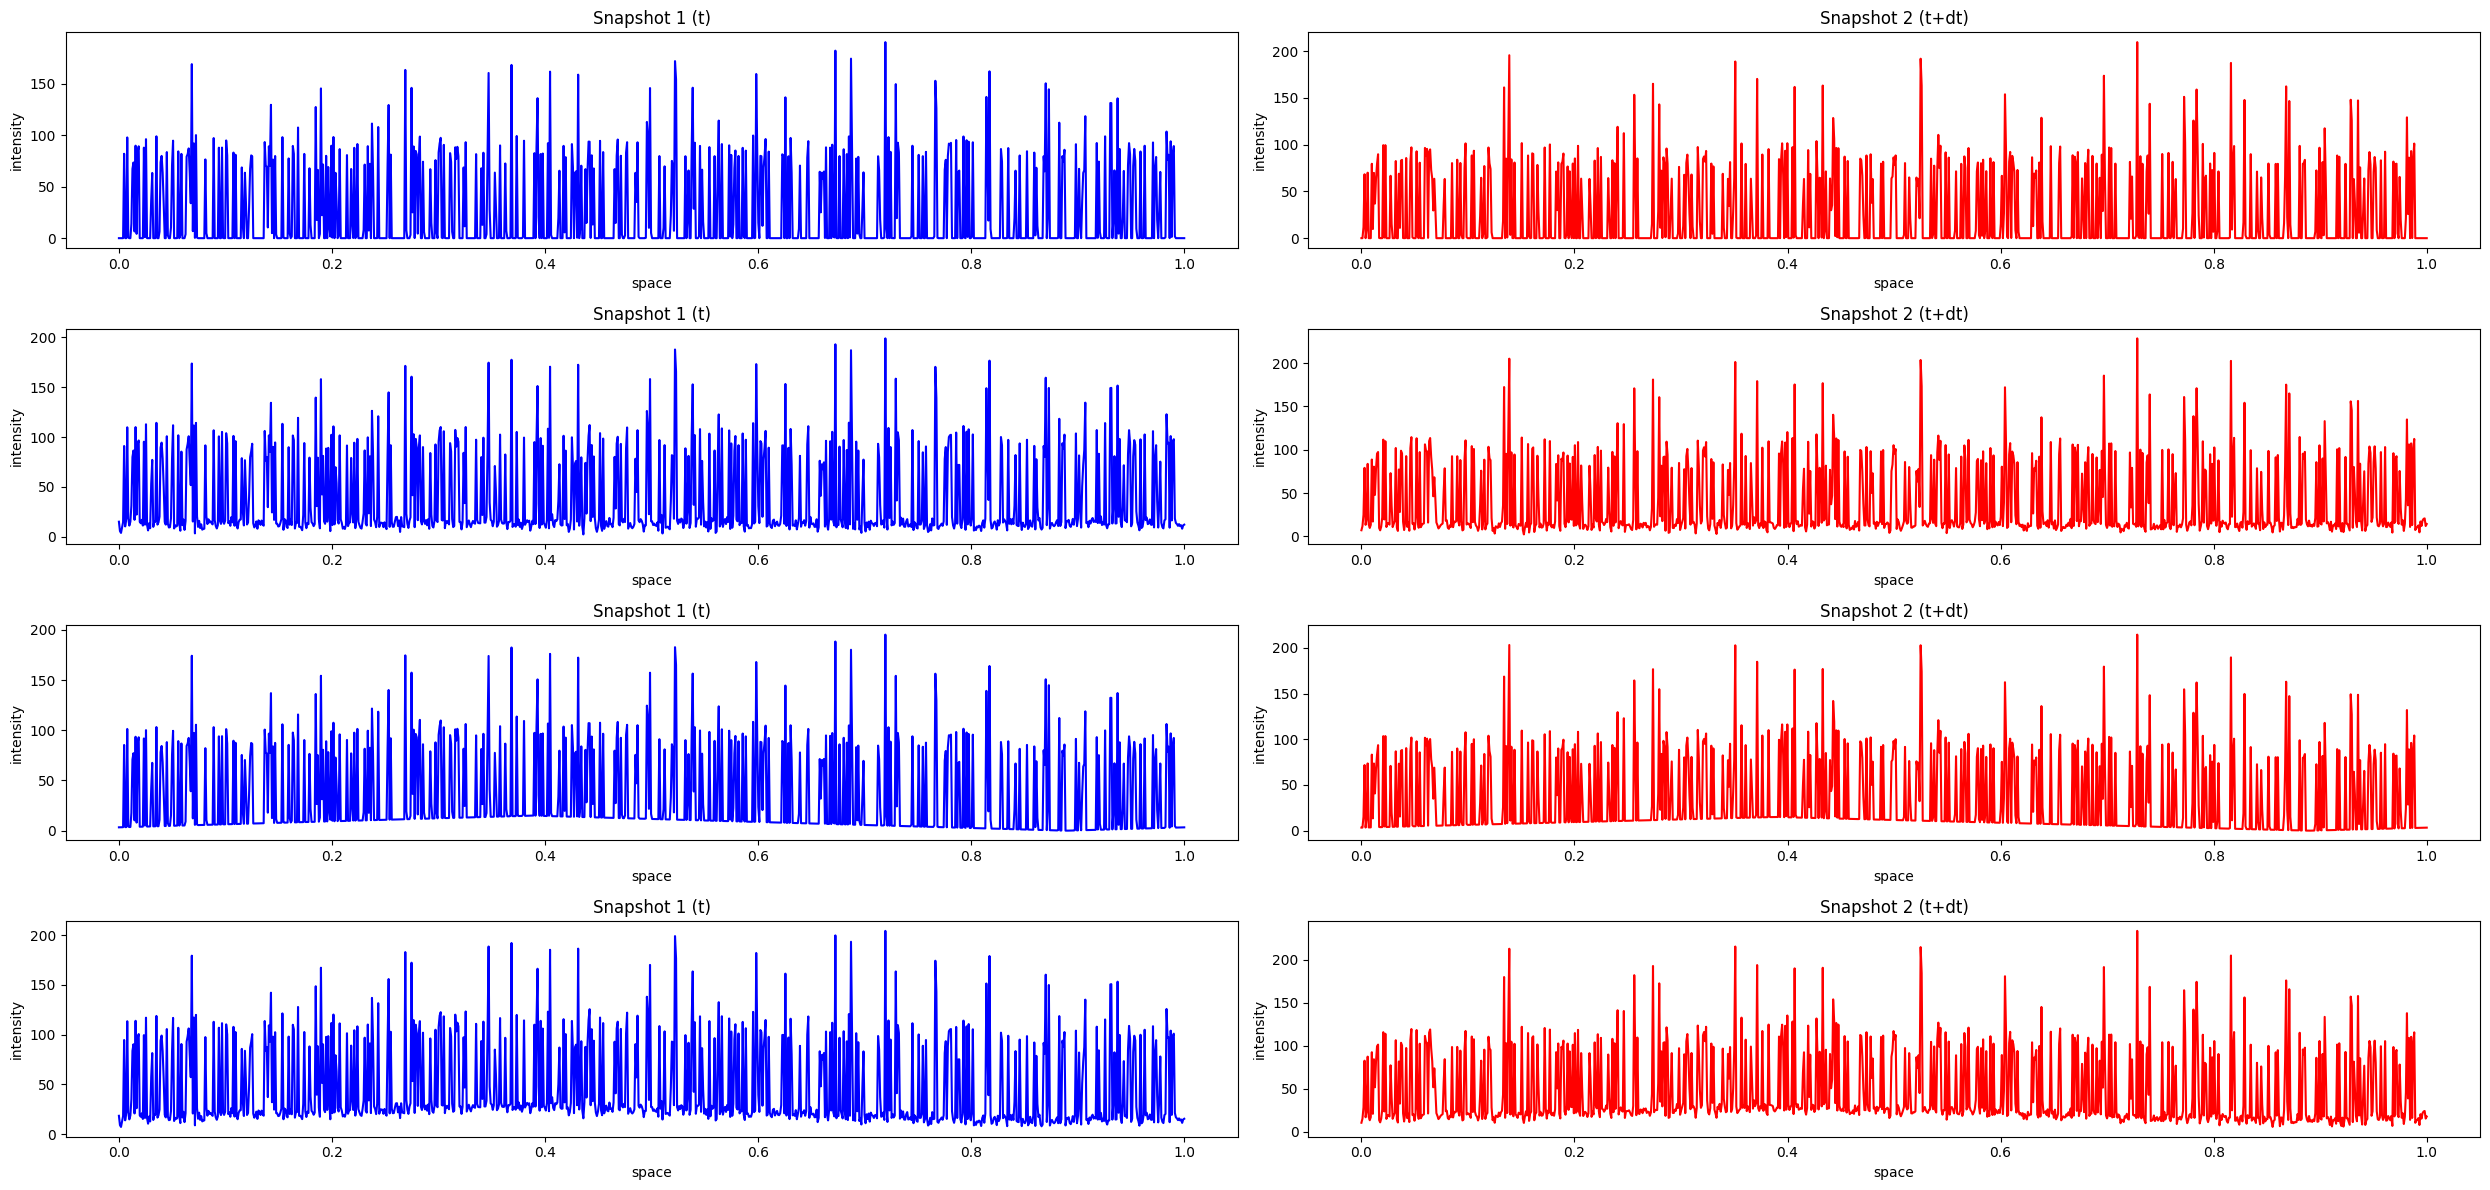

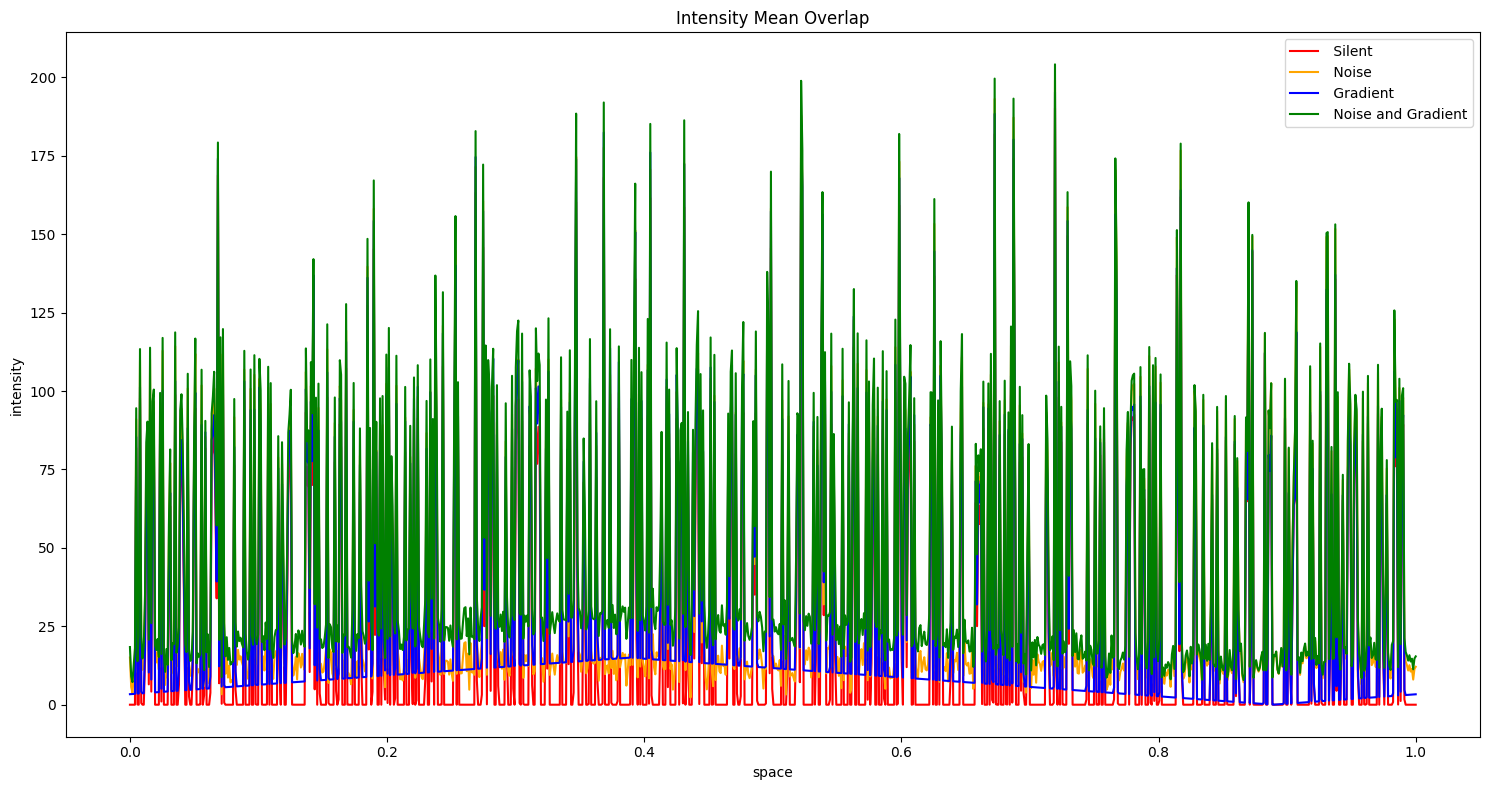

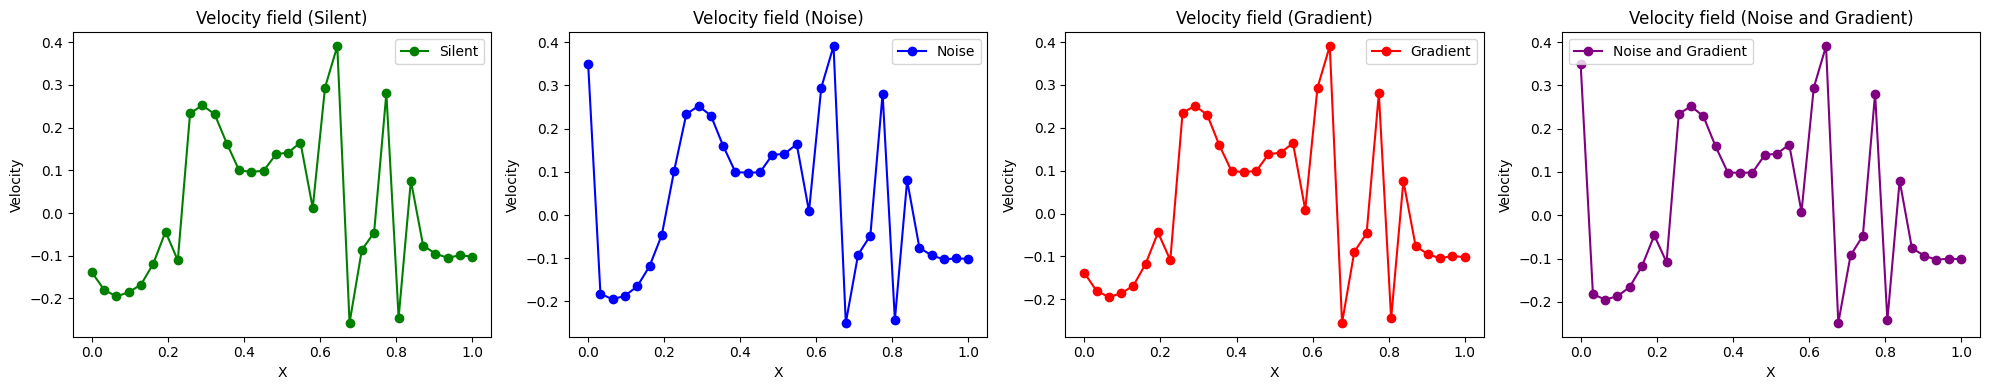

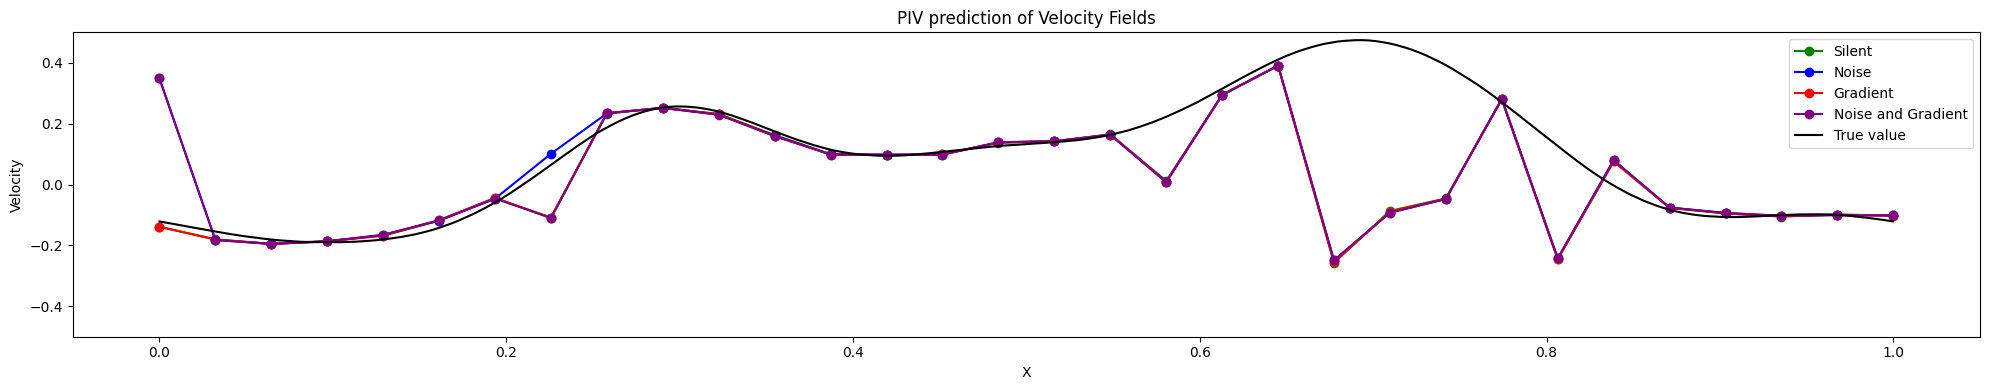

<Axes: title={'center': 'PIV prediction of Velocity Fields'}, xlabel='X', ylabel='Velocity'>

In [ ]:
intensity_mean_graph()
intensity_mean_overlap_graph()
all_PIV_velocity_field_plots()
all_overlap_PIV_velocity_field_plots()